In [18]:
import numpy as np
import pandas as pd
import datetime, json
import keras
from keras.models import Model
from keras.layers import Input, TimeDistributed, Dense, Lambda, Concatenate, Dropout, BatchNormalization, Dot, Permute
from keras.layers.embeddings import Embedding
from keras.regularizers import l2
from keras.callbacks import Callback, ModelCheckpoint
from keras import backend as K
from sklearn.model_selection import train_test_split
from time import time
from sklearn.metrics import confusion_matrix, f1_score
%matplotlib inline

In [19]:
MAX_SEQ_LENGTH = 25
L2 = 1e-5
DROUPOUT_PROB = 0.1

Q1_TRAINING_DATA_FILE = 'q1_train_{0}.npy'
Q2_TRAINING_DATA_FILE = 'q2_train_{0}.npy'
LABEL_TRAINING_DATA_FILE = 'label_train.npy'
WORD_EMBEDDING_MATRIX_FILE = 'word_embedding_matrix.npy'
NB_WORDS_DATA_FILE = 'nb_words.json'
VALIDATION_SPLIT = 0.1
EMBEDDING_DIM = 300
TEST_SPLIT = 0.1
RNG_SEED = 102203
NB_EPOCHS = 100
BATCH_SIZE = 100
MODEL_WT_FILE = 'decomposable_att_model_{0}.h5'

In [20]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [21]:
labels = np.load(open(LABEL_TRAINING_DATA_FILE,'rb'))
word_embedding = np.load(open(WORD_EMBEDDING_MATRIX_FILE, 'rb'))
with open(NB_WORDS_DATA_FILE, 'r') as f:
    nb_words = json.load(f)['nb_words']

In [22]:
#partition data into train/val set
q1data = np.load(open(Q1_TRAINING_DATA_FILE.format(MAX_SEQ_LENGTH), 'rb'))
q2data = np.load(open(Q2_TRAINING_DATA_FILE.format(MAX_SEQ_LENGTH), 'rb'))
X = np.stack((q1data, q2data), axis=1)
y = labels
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_SPLIT, random_state=RNG_SEED)
Q1_train = X_train[:,0]
Q2_train = X_train[:,1]
Q1_test = X_test[:,0]
Q2_test = X_test[:,1]

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 25)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 25)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 25, 300)      23750700    input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 25, 300)      23750700    input_2[0][0]                    
__________________________________________________________________________________________________
time_distr

Train on 327474 samples, validate on 36387 samples
Epoch 1/50
 - 129s - loss: 0.5136 - acc: 0.7390 - val_loss: 0.4686 - val_acc: 0.7629
Epoch 2/50
 - 131s - loss: 0.4438 - acc: 0.7776 - val_loss: 0.4277 - val_acc: 0.7864
Epoch 3/50
 - 136s - loss: 0.4203 - acc: 0.7928 - val_loss: 0.4205 - val_acc: 0.7948
Epoch 4/50
 - 137s - loss: 0.4030 - acc: 0.8040 - val_loss: 0.4116 - val_acc: 0.7964
Epoch 5/50
 - 138s - loss: 0.3901 - acc: 0.8114 - val_loss: 0.3972 - val_acc: 0.8067
Epoch 6/50
 - 137s - loss: 0.3791 - acc: 0.8181 - val_loss: 0.3972 - val_acc: 0.8091
Epoch 7/50
 - 138s - loss: 0.3684 - acc: 0.8245 - val_loss: 0.3899 - val_acc: 0.8094
Epoch 8/50
 - 138s - loss: 0.3596 - acc: 0.8303 - val_loss: 0.3893 - val_acc: 0.8115
Epoch 9/50
 - 137s - loss: 0.3514 - acc: 0.8344 - val_loss: 0.3875 - val_acc: 0.8146
Epoch 10/50
 - 138s - loss: 0.3418 - acc: 0.8395 - val_loss: 0.3998 - val_acc: 0.8054
Epoch 11/50
 - 138s - loss: 0.3349 - acc: 0.8429 - val_loss: 0.3809 - val_acc: 0.8194
Epoch 12/50


(0.0, 1.0)

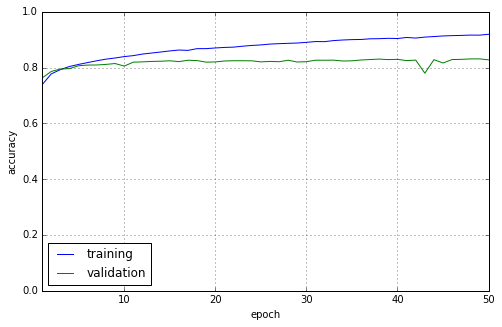

In [8]:
input_q1 = Input(shape=(MAX_SEQ_LENGTH,), dtype='int32')
input_q2 = Input(shape=(MAX_SEQ_LENGTH,), dtype='int32')

q1 = Embedding(nb_words + 1,
                  EMBEDDING_DIM,
                  weights=[word_embedding],
                  input_length=MAX_SEQ_LENGTH,
                  trainable=False)(input_q1)
    
q2 = Embedding(nb_words + 1,
                  EMBEDDING_DIM,
                  weights=[word_embedding],
                  input_length=MAX_SEQ_LENGTH,
                  trainable=False)(input_q2)

#Fully connected layer

q1 = TimeDistributed(Dense(300, 
                           activation='relu', 
                           #kernel_regularizer=l2(L2), 
                           #bias_regularizer=l2(L2)
                            ))(q1) #[batch_size, time_steps, num_units]
q2 = TimeDistributed(Dense(300, 
                           activation='relu', 
                           #kernel_regularizer=l2(L2), 
                           #bias_regularizer=l2(L2)
                            ))(q2) #[batch_size, time_steps, num_units]

#Attention

eij = Dot(axes= -1)([q1,q2])

#normalize attention

eik_norm = Lambda(lambda x:keras.activations.softmax(x, axis=1))(eij)
ekj_norm = Permute((2,1))(Lambda(lambda x:keras.activations.softmax(x, axis=2))(eij))
#ekj_norm = Lambda(lambda x:keras.activations.softmax(x))(K.transpose(eij))

beta = Dot(axes = 1)([eik_norm,q1])
alpha = Dot(axes = 1)([ekj_norm,q2])

#compare

q1_conc = Concatenate()([q1, alpha])
q2_conc = Concatenate()([q2, beta])

for i in range(2):
    score = TimeDistributed(Dense(500, #model 2 was 500
                           activation='relu',
                           #kernel_regularizer=l2(L2), 
                           #bias_regularizer=l2(L2)
                           ))
    
    q1_conc = score(q1_conc)
    q1_conc = Dropout(DROUPOUT_PROB)(q1_conc)
    q1_conc = BatchNormalization()(q1_conc)
    
    q2_conc = score(q2_conc)
    q2_conc = Dropout(DROUPOUT_PROB)(q2_conc)
    q2_conc = BatchNormalization()(q2_conc)
    
aggregate = Lambda(lambda X: K.reshape(K.sum(X, axis=1, keepdims=True), (-1, 500))) # model 2 was 500

v_1 = aggregate(q1_conc)
v_2 = aggregate(q2_conc)

final = Concatenate()([v_1,v_2])

for i in range(3):
        #2 * EMBEDDING_DIM : model 2 was 2
    final = Dense(500, activation= 'relu', 
                  #kernel_regularizer=l2(L2) 
                 )(final)
    final = Dropout(DROUPOUT_PROB)(final)
    final = BatchNormalization()(final)
        
pred = Dense(1, activation='sigmoid')(final)
    
model = Model(inputs=[input_q1,input_q2], outputs=pred)
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
    
print(model.summary())
t0 = time()
    
callbacks = [ModelCheckpoint(MODEL_WT_FILE.format('25_model_relu_noreg'), monitor='val_acc', save_best_only=True)]
train_states = model.fit([Q1_train, Q2_train],
                            y_train,
                            epochs = 50,#NB_EPOCHS,
                            validation_split=VALIDATION_SPLIT,
                            verbose=2,
                            batch_size=BATCH_SIZE,
                            callbacks=callbacks)
t1 = time()
print('Minutes elapsed: %f' % ((t1-t0)/60.0))

loss, accuracy = model.evaluate([Q1_test, Q2_test], y_test, verbose=0)
yhat =  model.predict([Q1_test, Q2_test])
rounded = [round(x[0]) for x in yhat]
f1s = f1_score(y_test,rounded,average='weighted')
    
print('loss = {0:.4f}, accuracy = {1:.4f}, f1-score = {1:.4f}'.format(loss, accuracy,f1s ))
    
#plot training and validation accuracy
acc = pd.DataFrame({'epoch': [ i + 1 for i in train_states.epoch ],
                        'training': train_states.history['acc'],
                        'validation': train_states.history['val_acc']})
ax = acc.iloc[:,:].plot(x='epoch', figsize={5,8}, grid=True)
ax.set_ylabel("accuracy")
ax.set_ylim([0.0,1.0])

In [6]:
#Decomposable Attention without regularization

input_q1 = Input(shape=(MAX_SEQ_LENGTH,), dtype='int32')
input_q2 = Input(shape=(MAX_SEQ_LENGTH,), dtype='int32')

q1 = Embedding(nb_words + 1,
                  EMBEDDING_DIM,
                  weights=[word_embedding],
                  input_length=MAX_SEQ_LENGTH,
                  trainable=False)(input_q1)
    
q2 = Embedding(nb_words + 1,
                  EMBEDDING_DIM,
                  weights=[word_embedding],
                  input_length=MAX_SEQ_LENGTH,
                  trainable=False)(input_q2)

#Fully connected layer

q1 = TimeDistributed(Dense(300, 
                           activation='relu', 
                           #kernel_regularizer=l2(L2), 
                           #bias_regularizer=l2(L2)
                            ))(q1) #[batch_size, time_steps, num_units]
q2 = TimeDistributed(Dense(300, 
                           activation='relu', 
                           #kernel_regularizer=l2(L2), 
                           #bias_regularizer=l2(L2)
                            ))(q2) #[batch_size, time_steps, num_units]

#Attention

eij = Dot(axes= -1)([q1,q2])

#normalize attention

eik_norm = Lambda(lambda x:keras.activations.softmax(x, axis=1))(eij)
ekj_norm = Permute((2,1))(Lambda(lambda x:keras.activations.softmax(x, axis=2))(eij))
#ekj_norm = Lambda(lambda x:keras.activations.softmax(x))(K.transpose(eij))

beta = Dot(axes = 1)([eik_norm,q1])
alpha = Dot(axes = 1)([ekj_norm,q2])

#compare

q1_conc = Concatenate()([q1, alpha])
q2_conc = Concatenate()([q2, beta])

for i in range(2):
    score = TimeDistributed(Dense(500, #model 2 was 500
                           activation='relu',
                           #kernel_regularizer=l2(L2), 
                           #bias_regularizer=l2(L2)
                           ))
    
    q1_conc = score(q1_conc)
    q1_conc = Dropout(DROUPOUT_PROB)(q1_conc)
    q1_conc = BatchNormalization()(q1_conc)
    
    q2_conc = score(q2_conc)
    q2_conc = Dropout(DROUPOUT_PROB)(q2_conc)
    q2_conc = BatchNormalization()(q2_conc)
    
aggregate = Lambda(lambda X: K.reshape(K.sum(X, axis=1, keepdims=True), (-1, 500))) # model 2 was 500

v_1 = aggregate(q1_conc)
v_2 = aggregate(q2_conc)

final = Concatenate()([v_1,v_2])

for i in range(3):
        #2 * EMBEDDING_DIM : model 2 was 2
    final = Dense(500, activation= 'relu', 
                  #kernel_regularizer=l2(L2) 
                 )(final)
    final = Dropout(DROUPOUT_PROB)(final)
    final = BatchNormalization()(final)
        
pred = Dense(1, activation='sigmoid')(final)
    
model = Model(inputs=[input_q1,input_q2], outputs=pred)
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])

loss = 0.3890, accuracy = 0.8199, f1-score = 0.8199
Normalized confusion matrix
             precision    recall  f1-score   support

          0       0.86      0.85      0.86     25529
          1       0.75      0.77      0.76     14900

avg / total       0.82      0.82      0.82     40429



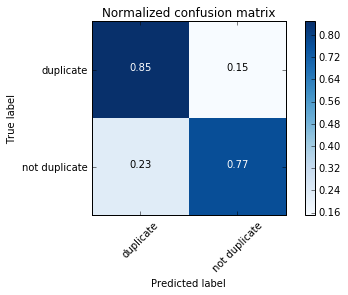

In [8]:
from sklearn.metrics import confusion_matrix, f1_score, classification_report

model.load_weights('decomposable_att_model_25_model_relu.h5')
loss, accuracy = model.evaluate([Q1_test, Q2_test], y_test, verbose=0)
yhat =  model.predict([Q1_test, Q2_test])
rounded_1 = [1 if x[0] >= 0.5 else 0 for x in yhat]

f1s = f1_score(y_test,rounded_1,average='weighted')
    
print('loss = {0:.4f}, accuracy = {1:.4f}, f1-score = {1:.4f}'.format(loss, accuracy,f1s ))


cnf_matrix = confusion_matrix(y_test, rounded_1)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['duplicate','not duplicate'], normalize=True,
                      title='Normalized confusion matrix')

print (classification_report(y_test,rounded_1 ))

In [9]:
df = pd.read_csv('train_cleaned.csv')
df.head()

,Unnamed: 0,id,qid1,qid2,question1,question2,is_duplicate,cleaned_q1,cleaned_q2
0,0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,step step guide invest share market india,step step guide invest share market
1,1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,story kohinoor koh noor diamond,would happen indian government stole kohinoor ...
2,2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,increase speed internet connection using vpn,internet speed increased hacking dns
3,3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,mentally lonely solve,find remainder math math divided
4,4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,one dissolve water quikly sugar salt methane c...,fish would survive salt water


In [10]:
dt_t, dt_te, y_t, y_te = train_test_split(df, y, test_size = TEST_SPLIT, random_state=RNG_SEED)

Normalized confusion matrix
             precision    recall  f1-score   support

          0       0.86      0.85      0.86     25529
          1       0.75      0.77      0.76     14900

avg / total       0.82      0.82      0.82     40429



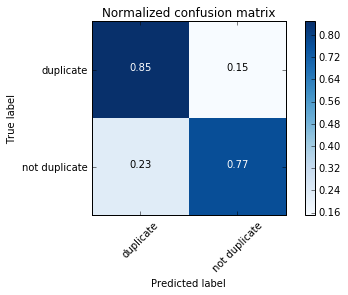

In [11]:
from sklearn.metrics import confusion_matrix, f1_score, classification_report

rounded_1 = [1 if x[0] > 0.5 else 0 for x in yhat]

cnf_matrix = confusion_matrix(y_test, rounded_1)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['duplicate','not duplicate'], normalize=True,
                      title='Normalized confusion matrix')

print (classification_report(y_test,rounded_1 ))


In [13]:
error = [i==j for i, j in zip(y_test, rounded_1) ] 

correct_class = [i for i, x in enumerate(error) if x]
wrong_class = [i for i, x in enumerate(error) if not x]

In [16]:
dt_te.iloc[correct_class][['question1','question2','is_duplicate']]

,question1,question2,is_duplicate
285553,Where can I get a legal wholesale provider of ...,What is the list of legit wholesale suppliers ...,1
121590,Who is your favorite electronic producer?,Who are your favorite music producer(s) of the...,0
138125,Corporate Finance: What do computer science gr...,What are some pros and cons of working in corp...,0
223628,What application model allows Spotify to keep ...,Are there any apps that allow me to play MP4 f...,0
120727,Why do a lot of people sneeze a lot after waki...,Why do people fart more when they wake up in t...,0
54185,Where can I find subtitles for Daylight's End?,"Which is the best 50"" tv to buy in India? Very...",0
390687,How can I lose fat in 2 weeks?,How can I reduce my weight in just 21 days?,0
304984,Why does rate of interest for education loan i...,If I has a crush on God would that be extremel...,0
351533,What does superbcrew.com do?,What is flixcart.com?,0
379125,Which startups are best positioned to compete ...,Dun & Bradstreet: Is it useful to have DnB num...,0


In [17]:
dt_te.iloc[wrong_class][['question1','question2','is_duplicate']]

,question1,question2,is_duplicate
331161,What is the easiest way to learn java programm...,What is the Best and fast way to learn Java an...,0
32634,What is the idea behind the name Quora?,Why is Quora called Quora?,0
184948,How can I prevent an idea from being copied?,How can I protect my ideas from being stolen?,1
280589,What is Bitcoin currency?,Is Bitcoin a currency?,0
249862,Do I have to have a credit card or bank accoun...,How can I open PayPal without a bank account?,1
258679,What are the steps for registering a company i...,What are the steps to start a company in India?,0
203947,Why did they make the Star Wars movies out of ...,Why was Star Wars released in such a strange o...,1
236223,I have an untreatable and life-long disabling ...,What would be a cool way to commit suicide?,1
44975,What are the hours for McDonald's breakfast menu?,Do all McDonald's have the same breakfast hour...,1
187264,What is the reputation of Portuguese people am...,"As a Portuguese I'm curious, what do people fr...",1


In [14]:
from keras.utils import plot_model
plot_model(model, to_file='decomp_model.png')

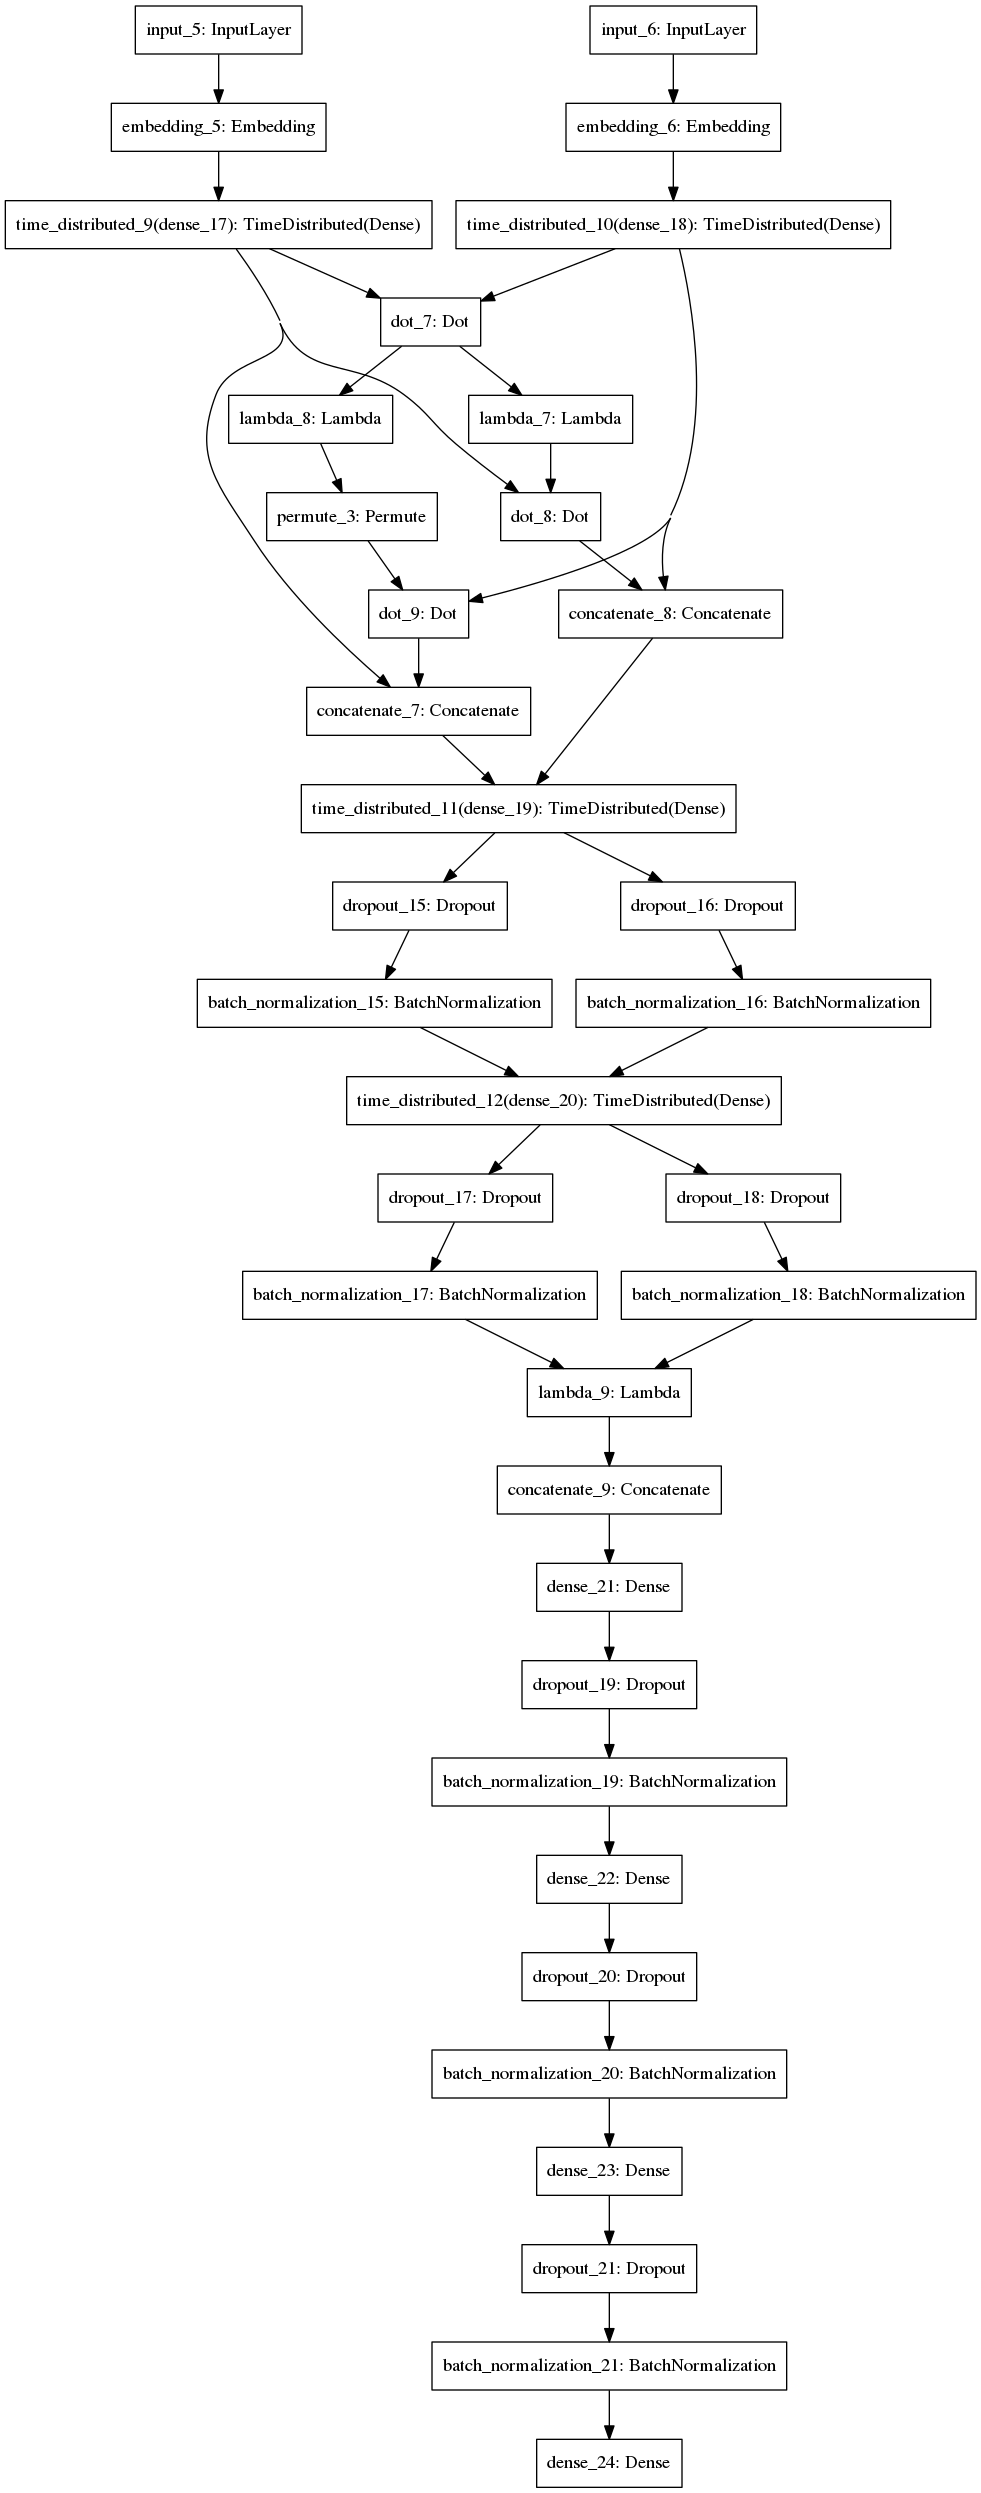

In [15]:
from IPython.display import Image
Image(filename='decomp_model.png') 